# Лабораторная работа 1: Парабола

## Вариант 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings

np.set_printoptions(precision=4)

a = 1/10
b,c = 0, 0
l = 1 #length
alpha, gamma = 0, 0
beta, delta = 1, 1

get_left_bound = lambda t : 0
get_right_bound = lambda t : 1
get_initial_values = lambda x : x + np.sin(np.pi*x)

analit_function = lambda x, t : x + np.exp(-np.pi*np.pi*t*a)*np.sin(np.pi*x)

In [2]:
def plot_function(function, time_stop, x_num, t_num, curr_t, *, w=None):
    time_step = time_stop / (t_num - 1)
    grid = function(space_stop=l, space_num=x_num, 
                    time_stop=time_stop, time_num=t_num, approx_type='2o3p')

    points = np.linspace(0.0, l, x_num)
    analyt_solution = analit_function(points, (curr_t-1) * time_step)
    grid_solution   = grid[curr_t-1]

    error = np.mean( np.square(analyt_solution - grid_solution) )
    print(f"MSError: {error:.10f}")

    plt.plot(points, grid_solution, label="Numerical solution")
    plt.plot(points, analyt_solution, label="Analytical solution")
    plt.grid()
    plt.legend()

## Явный метод

### Алгоритм

In [3]:
def solve_explicit(*, space_start=0.0, space_stop=1.0, space_num=200,
                      time_start=0.0,  time_stop=1.0,  time_num=200,
                      approx_type='1o2p'):
    space_step = (space_stop - space_start) / (space_num - 1)
    time_step = (time_stop - time_start) / (time_num - 1)

    sigma = a * time_step / (space_step*space_step)
    print('Sigma: ', sigma)
    if sigma >= 0.5:
        warnings.warn("Sigma reached 0.5, solution is unstable")
    
    grid = np.zeros((time_num, space_num))
    grid[0, :] = get_initial_values( np.linspace(space_start, space_stop, space_num) )
    
    for t in range(time_num - 1):
        for x in range(1, space_num - 1):
            coef = a * time_step / (space_step*space_step)
            diffusion = coef * ( grid[t, x+1] - 2*grid[t, x] + grid[t, x-1] )
            
            grid[t+1, x] = grid[t, x] + diffusion
        
        if approx_type == '1o2p':
            grid[t+1, 0]  = get_left_bound((t+1) * time_step) #/ beta 
            grid[t+1, -1] = get_right_bound((t+1) * time_step) #/ delta
            
        elif approx_type == '2o3p':
            grid[t+1, 0]  = get_left_bound((t+1) * time_step) #/beta
            grid[t+1, -1] = get_right_bound((t+1) * time_step) #/delta 
            
  #      elif approx_type == '2o2p':
  #          grid[t+1, 0]  = (space_step/time_step * grid[t, 0] - get_left_bound((t+1) * time_step) * (2*a*a - b*space_step)/alpha + 2*a*a/space_step * grid[t+1, 1]) / ( 2*a*a/space_step + space_step/time_step - c * space_step + beta/alpha * (2*a*a - b*space_step) )
  #          grid[t+1, -1] = (space_step/time_step * grid[t, -1] - get_right_bound((t+1) * time_step) * (2*a*a + b*space_step)/gamma + 2*a*a/space_step * grid[t+1, -2]) / (2*a*a/space_step + space_step/time_step - c * space_step + delta/gamma * (2*a*a + b*space_step))
            
    return grid

### Пример решения

Sigma:  0.013545150501672243
MSError: 0.0000035513


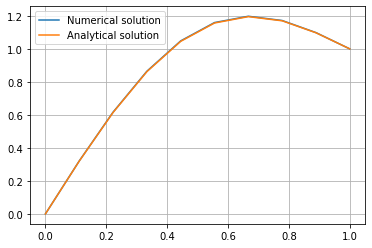

In [4]:
time_stop = 0.5

x_num, t_num, curr_t = 10, 300, 300

plot_function(solve_explicit, time_stop, x_num, t_num, curr_t)

## Неявный метод

### Метод прогонки

In [5]:
def solve_tridiagonal(lower, mid, upper, constraints):
    a, b, c, d = map(np.array, (lower, mid, upper, constraints, ))
    x = np.zeros_like(d)
    n = len(d)
    
    for i in range(1, n):
        w = a[i] / b[i - 1]
        b[i] -= w * c[i - 1]
        d[i] -= w * d[i - 1]
    
    x[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]
        
    return x

### Алгоритм

In [6]:
def solve_implicit(*, space_start=0.0, space_stop=1.0, space_num=200,
                      time_start=0.0,  time_stop=1.0,  time_num=200,
                      w = 0.5, approx_type='1o2p'):
    space_step = (space_stop - space_start) / (space_num - 1)
    time_step = (time_stop - time_start) / (time_num - 1)
    
    grid = np.zeros((time_num, space_num))
    grid[0, :] = get_initial_values( np.linspace(space_start, space_stop, space_num) )
    
    for t in range(time_num - 1):
        lower  = np.zeros((space_num, ))
        mid    = np.zeros((space_num, ))
        upper  = np.zeros((space_num, ))
        constr = np.zeros((space_num, ))
        
        lower[1:-1] = w * a / (space_step*space_step)
        mid[1:-1]   = w * (- 2 * a / (space_step*space_step)) - 1 / time_step
        upper[1:-1] = w * a / (space_step*space_step)
        
        for x in range(1, space_num - 1):
            diff_coef = a / (space_step*space_step)
            move_coef = 0
            infl_coef = 0
            constr[x] = (w - 1) * ( diff_coef * (grid[t, x+1] - 2 * grid[t, x] + grid[t, x-1])) - grid[t, x] / time_step

        if approx_type == '1o2p':
            mid[0]    = beta / space_step
            upper[0]  = 0
            constr[0] = get_left_bound((t+1) * time_step)

            lower[-1]  = 0
            mid[-1]    = delta
            constr[-1] = get_right_bound((t+1) * time_step)
            
        elif approx_type == '2o3p':
            mid[0]    = beta
            upper[0]  =  0
            constr[0] = get_left_bound((t+1) * time_step)
            
            lower[-1]  = 0
            mid[-1]    = delta
            constr[-1] = get_right_bound((t+1) * time_step)
            

        #elif approx_type == '2o2p':
        #    mid[0]    = 2*a*a/space_step + space_step/time_step - c * space_step - beta/alpha * (2*a*a - b*space_step)
        #    upper[0]  = -2*a*a/space_step
        #    constr[0] = space_step/time_step * grid[t, 0] - get_left_bound((t+1) * time_step) * (2*a*a - b*space_step)/alpha
            
        #    lower[-1]  = -2*a*a/space_step
        #    mid[-1]    = 2*a*a/space_step + space_step/time_step - c * space_step + delta/gamma * (2*a*a + b*space_step)
        #    constr[-1] = space_step/time_step * grid[t, -1] + get_right_bound((t+1) * time_step) * (2*a*a + b*space_step)/gamma
            
        grid[t+1] = solve_tridiagonal(lower, mid, upper, constr)
        
    return grid

### Пример решения

MSError: 0.0000003683


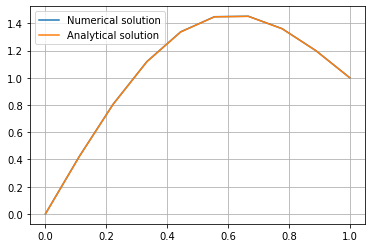

In [7]:
time_stop = 0.1

x_num, t_num, curr_t = 10, 300, 300

plot_function(solve_implicit, time_stop, x_num, t_num, curr_t, w=1.0)

## Метод Кранка - Николсона

### Пример решения

MSError: 0.0000000000


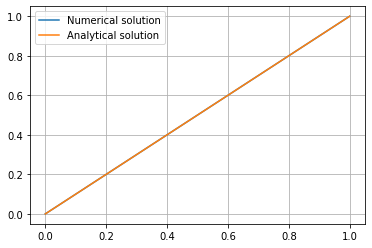

In [8]:
time_stop = 10

x_num, t_num, curr_t = 10, 300, 300

plot_function(solve_implicit, time_stop, x_num, t_num, curr_t, w=0.5)